# Exploratory Data Analysis

This notebook objective is to compare and contrast the 2 subreddit websites, 'r/GoogleHome' and 'r/AmazonEcho', and highlight any associate relationships or otherwise. Simple comparisons such as word counts will be done. Feature techniques such as stemmer and lemmatization shall be used in finding common words used.

A sentiment analysis would be conducted to find the average sentiment value of posts in the respective subreddits. Along with regular expression to find specific key words or terms.  

## Problem Statement

Google's smart speaker system, Google Home, was designed to compete with the popular Amazon Echo. Both product serve as a vehicle to their respective voice-activated virtual helper that connects to the internet. 

Reddit users have used the platform as a forum to discuss their experience with the products. I had been tasked by Google's Research team to analyze customer sentiment towards Google Home from subreddit posts on 'r/GoogleHome'.

Additionally the Research Team would also like to find out what common and unique customer pain points are prevalent between the Google Home and Amazon Echo, with the goal of designing a better product. Therefore subreddit posts from 'r/AmazonEcho' would also be included in the dataset.

A Random Forrest model would also be built to predict if a given set of words do in fact refer to the discussion of either the Amazon Echo or the Google Home based on selected features. 

Each subreddit post are represented as 'documents' in the dataset and therefore both terms will be used interchangebly.


**Contents**
- [Import libraries](#Import-libraries)
- [Load data](#Load-data)
- [Feature engineering](#Feature-engineering)
    - [Create 'url_in_text' column](#Create-'url_in_text'-column)
    - [Separate 'url_in_text' columns into linktype column](#Separate-'url_in_text'-columns-into-linktype-column)
    - [Bin similar 'topic' together](#Bin-similar-'topic'-together)
- [Check for links to customer support website or mention of site](#Check-for-links-to-customer-support-website-or-mention-of-site)
- [Investigate relationship between topic and linktype](#Investigate-relationship-between-topic-and-linktype)
- [Find distribution of word counts](#Find-distribution-of-word-counts)
- [Find most frequently used words and bigrams](#Find-most-frequently-used-words-and-bigrams)
- [Sentiment Analysis with Vader lexicon](#Sentiment-Analysis-with-Vader-lexicon)
- [Conclusion](#Conclusion)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import text 

## Load data

In [2]:
#import data
subreddit_data = pd.read_csv(r'../datasets/clean_data.csv')

In [3]:
#Show distribution of y target class
subreddit_data.subreddit.value_counts()

amazonecho    2968
googlehome    2767
Name: subreddit, dtype: int64

In [4]:
#check general information of df
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit               5735 non-null   object
 1   author                  5735 non-null   object
 2   full_link               5735 non-null   object
 3   num_comments            5735 non-null   int64 
 4   url_overridden_by_dest  987 non-null    object
 5   selftext                5735 non-null   object
 6   title                   5735 non-null   object
 7   link_flair_text         3197 non-null   object
dtypes: int64(1), object(7)
memory usage: 358.6+ KB


In [5]:
#rename the dataset columns
subreddit_data.rename(columns={"subreddit":"subreddit_",
                               "author":"author_",
                              "selftext":"selftext_",
                              "title":"title_",
                               "link_flair_text":"topic"
                              },inplace=True)

In [6]:
#show target class distribution 

subreddit_data.subreddit_.value_counts(normalize=True)

amazonecho    0.517524
googlehome    0.482476
Name: subreddit_, dtype: float64

## Feature Engineering

### Check for links in selftext against url_overidden_by_dest

What had been predetermined in the ETL notebook was that post with no selftext, but with an image or link, returned the url of that image or link in 'url_overridden_by_dest'.

However during general data exploration, what had not been taking into consideration were whether post with text in the selftext class had links or images, and whether that was reflected in 'url_overridden_by_dest'.

Below will show an example of this finding.

In [7]:
#search for post that had begun with the sentence below that also had a link
new_string = "I've seen Reddit users link to this"

In [8]:
#search for string and its respective index for furhter investigation

index = -1
for x in subreddit_data.selftext_:
    index += 1
    if new_string in x:
        print (x)
        print ('\n')
        print (f'Example string row location: {index}')

I've seen Reddit users link to this: https://www.cnbc.com/2020/11/09/how-to-stop-amazon-echo-from-asking-you-to-buy-stuff.html

And tell users to disable all Shopping Notifications, or turning off notifications in general. 

THESE DO NOT STOP BY THE WAY MESSAGES, SO FOR THE LOVE OF JEFF FUCKING BEZOS, STOP RECOMMENDING IT EVERY TIME A COMMENT OR POSTS MENTIONS THIS. The Alexa "by the way" shit are not notifications (i.e the yellow glow rings). All your doing is disabling the shopping notifications for what Amazon thinks you want to buy, both are annoying, but are not the same thing. 

If the mods could create a sticky in the sidebar telling people this, or create an automod script that tells people that there is no current way to disable these notifications, this subreddit wouldn't be spammed with people who don't understand what a person is asking about giving non relevant answers to problems they never asked about.


Example string row location: 4518


In [9]:
# show information of document

subreddit_data.iloc[4518,:]

subreddit_                                                       amazonecho
author_                                                        WhistlerBlue
full_link                 https://www.reddit.com/r/amazonecho/comments/k...
num_comments                                                             23
url_overridden_by_dest                                                  NaN
selftext_                 I've seen Reddit users link to this: https://w...
title_                    PSA: Disabling Notifications for Alexa Shoppin...
topic                                                               Feature
Name: 4518, dtype: object

What we can observe from above that eventhough there is a link in the selftext class, the url_overridden_by_dest is still nan. 

Moving forward what I would do is search within the documents selftext's for links, and create a new column called 'url_in_text' with these urls. 

### Create 'url_in_text' column

In [10]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit_              5735 non-null   object
 1   author_                 5735 non-null   object
 2   full_link               5735 non-null   object
 3   num_comments            5735 non-null   int64 
 4   url_overridden_by_dest  987 non-null    object
 5   selftext_               5735 non-null   object
 6   title_                  5735 non-null   object
 7   topic                   3197 non-null   object
dtypes: int64(1), object(7)
memory usage: 358.6+ KB


In [11]:
#remove links in selftext column

subreddit_data['url_in_text'] = None

#use for loop to iterate through all df
for row in range(0,len(subreddit_data)):
    url_in_txt = re.search('(http|https)\S*',subreddit_data.iat[row,5]) #return first link found in selftext
    if url_in_txt is None:    
        pass                   #if there is no search result, pass
    else:
        subreddit_data.iat[row,8] = url_in_txt.group()   #return search result

In [12]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit_              5735 non-null   object
 1   author_                 5735 non-null   object
 2   full_link               5735 non-null   object
 3   num_comments            5735 non-null   int64 
 4   url_overridden_by_dest  987 non-null    object
 5   selftext_               5735 non-null   object
 6   title_                  5735 non-null   object
 7   topic                   3197 non-null   object
 8   url_in_text             221 non-null    object
dtypes: int64(1), object(8)
memory usage: 403.4+ KB


In [13]:
#check to see if url_in_txt and url_overdriven_by_dest are the same

row_same_url = []

for row in range(0,len(subreddit_data)):
    if subreddit_data.iat[row,8] == subreddit_data.iat[row,4]:
        row_same_url.append(row)
    else:
        pass

In [14]:
#show rows where url_in_txt and url_overdriven_by_dest have the same url
subreddit_data.iloc[row_same_url,:]

,subreddit_,author_,full_link,num_comments,url_overridden_by_dest,selftext_,title_,topic,url_in_text
1185,googlehome,EndFirm5463,https://www.reddit.com/r/googlehome/comments/l...,0,https://free-ned.club/gifts/r/h19igg5e,https://free-ned.club/gifts/r/h19igg5e,https://free-ned.club/gifts/r/h19igg5e,NaN,https://free-ned.club/gifts/r/h19igg5e
1778,googlehome,Jo4k3er91,https://www.reddit.com/r/googlehome/comments/l...,0,https://cryptotabbrowser.com/19067680,https://cryptotabbrowser.com/19067680,https://cryptotabbrowser.com/19067680,NaN,https://cryptotabbrowser.com/19067680


As only the two rows above have the same url in both columns, with characteristic of it being spam or a promotional post, these posts will be dropped. 

Additionally, moving forward, assuming that urls do not overlap as well, I will combine the column as one. We should therefore have 1208 values in this column. 

In [15]:
#drop above rows

subreddit_data.drop([1185,1778],axis=0,inplace=True)

#reset df index

subreddit_data.reset_index(drop=True, inplace=True)

#replace rows that are None and NaN

subreddit_data['url_in_text'].replace([None],'',inplace=True)

subreddit_data['url_overridden_by_dest'].replace(np.nan,'',inplace=True)

In [16]:
#combine the two columns together

subreddit_data['has_url'] = subreddit_data['url_in_text'] + subreddit_data['url_overridden_by_dest'] 

In [17]:
#replace columns with empty string back to np.nan

subreddit_data['has_url'].replace('',np.nan,inplace=True)

subreddit_data['url_in_text'].replace('',np.nan,inplace=True)

subreddit_data['url_overridden_by_dest'].replace('',np.nan,inplace=True)

In [18]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit_              5733 non-null   object
 1   author_                 5733 non-null   object
 2   full_link               5733 non-null   object
 3   num_comments            5733 non-null   int64 
 4   url_overridden_by_dest  985 non-null    object
 5   selftext_               5733 non-null   object
 6   title_                  5733 non-null   object
 7   topic                   3197 non-null   object
 8   url_in_text             219 non-null    object
 9   has_url                 1198 non-null   object
dtypes: int64(1), object(9)
memory usage: 448.0+ KB


In [19]:
print(f"Google Home posts with links: {subreddit_data[subreddit_data.subreddit_=='googlehome']['has_url'].value_counts().sum()}")
print(f"Amazon Echo posts with links: {subreddit_data[subreddit_data.subreddit_=='amazonecho']['has_url'].value_counts().sum()}")

Google Home posts with links: 652
Amazon Echo posts with links: 546


In total we have 1198 documents with links, after 2 had been dropped and 8 that were overlapping. 

Moving forward, this column would be used for further analysis such as transforming them via one hot encoding to be trained on our model. However before doing so, we will separate the urls between images and links to other sites. 


### Separate 'url_in_text' columns into linktype columns

In [20]:
#urls that are images in reddit post begin with 'imgur','png' or 'jpg'

#create new column categorizing if url is link or image

subreddit_data['linktype'] = None

for row in range(0,len(subreddit_data)):
        try:
            """use 'except' to avoid error from np.nan that is a float value,
    if no error, search for image and return 'image' else return 'link'"""
            url = re.search('(imgur|png|jpg)',subreddit_data.iat[row,9])
            if url is None:
                subreddit_data.iat[row,10] = 'link'
            else:
                subreddit_data.iat[row,10] = 'image'
        except:
            subreddit_data.iat[row,10] = 'none'


In [21]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit_              5733 non-null   object
 1   author_                 5733 non-null   object
 2   full_link               5733 non-null   object
 3   num_comments            5733 non-null   int64 
 4   url_overridden_by_dest  985 non-null    object
 5   selftext_               5733 non-null   object
 6   title_                  5733 non-null   object
 7   topic                   3197 non-null   object
 8   url_in_text             219 non-null    object
 9   has_url                 1198 non-null   object
 10  linktype                5733 non-null   object
dtypes: int64(1), object(10)
memory usage: 492.8+ KB


In [22]:
#show distribution of linktype
subreddit_data.linktype.value_counts()

none     4535
link      774
image     424
Name: linktype, dtype: int64

In [23]:
subreddit_data.groupby(by='subreddit_')['linktype'].value_counts()

subreddit_  linktype
amazonecho  none        2422
            link         380
            image        166
googlehome  none        2113
            link         394
            image        258
Name: linktype, dtype: int64

|             	| No. of Posts 	| No.of post w/ image 	| No. of Post w/ link 	| 
|-------------	|--------------	|---------------------	|---------------------	|
| Google Home 	| 2968         	| 258                 	| 394                 	| 
| Amazon Echo 	| 2767         	| 165                 	| 381|

### Bin similar 'topic' together

In [24]:
subreddit_data['topic'].value_counts()

Question                       1424
Help                            692
Technical Issue                 398
Bug                             163
Review                           84
Other                            81
Feature                          54
Commands | How To's              52
Tips                             46
Feature Request                  44
Alexa Skill                      42
Features WishList                24
News                             23
Hacks                            15
Deals | Sales | Promotions       14
NSFW - Language                  11
Skill Request                    10
Product Review                    8
GH Trigger Warning                7
Easter Egg                        5
Name: topic, dtype: int64

The purpose of separating images and url is to see if there is any correlation between them and the respective subreddits and the topic category. My assumption is that images would appear more in topic associated with issues with the product such as 'Question','Technical Issue', 'Help', 'Bug', 'Commands | How To's' and 'Alexa Skill'. 

'Features WishList', 'Feature Request' and 'Skill Request' are also the same where author express what they would like to have in the next generation of products. Followed by 'Hacks' and 'Tips' where authors share how they have a interesting workaround to their problems. And 'Product Review' and 'Review'.

It would be better to bin these categories together as it would be result in a more accurate prediction in our model. 

In [25]:
#Bin categories accordingly within topic column

#set lists of categories to replace

issues_list = ["Technical Issue","Help","Bug","Commands | How To's","Alexa Skill","Question"]

feature_wishlist = ["Features WishList","Feature Request","Skill Request","Feature"]

tip_list = ['Hacks','Tips']

product_review_list = ['Product Review','Review']

#bin categories accordingly 

subreddit_data['topic'] = subreddit_data['topic'].replace(issues_list,'issues')

subreddit_data['topic'] = subreddit_data['topic'].replace(feature_wishlist,'feature wishlist')

subreddit_data['topic'] = subreddit_data['topic'].replace(tip_list,'tips')

subreddit_data['topic'] = subreddit_data['topic'].replace(product_review_list,'product review')

subreddit_data['topic'] = subreddit_data['topic'].replace('Deals | Sales | Promotions ','deals')

In [26]:
subreddit_data['topic'].value_counts()

issues                2771
feature wishlist       132
product review          92
Other                   81
tips                    61
News                    23
deals                   14
NSFW - Language         11
GH Trigger Warning       7
Easter Egg               5
Name: topic, dtype: int64

In [27]:
subreddit_data['topic'].value_counts()

issues                2771
feature wishlist       132
product review          92
Other                   81
tips                    61
News                    23
deals                   14
NSFW - Language         11
GH Trigger Warning       7
Easter Egg               5
Name: topic, dtype: int64

In [28]:
subreddit_data['topic'].value_counts().sum()

3197

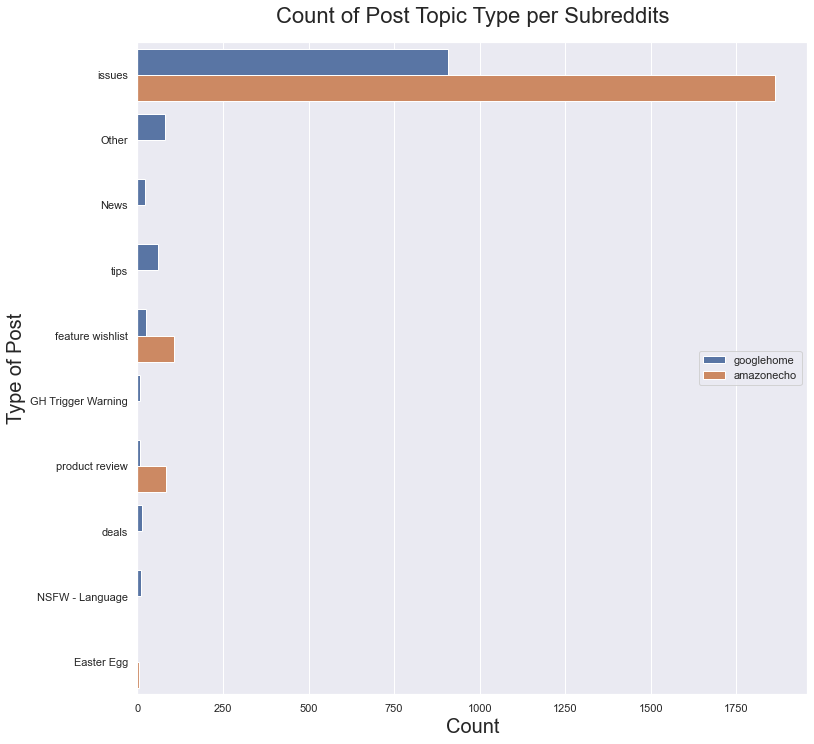

In [29]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 12))
sns.countplot( y="topic", hue="subreddit_", data=subreddit_data,)
plt.title("Count of Post Topic Type per Subreddits", y=1.02, fontsize = 22)
plt.xlabel("Count",fontsize=20)
plt.ylabel("Type of Post",fontsize=20)
plt.legend(loc=7)
plt.savefig(r'../images/count-of-post-topic-type.png');

Based on the above barplot, where we only have 3196 that are labelled to have a type of post, we can still clearly see that a majority in both subreddits are posts pertaining to troubleshooting. 

From here, I would like to know if people posting are mentioning the respective customer support sites as a solution to their issues.

## Check for links to customer support website or mention of site

In [30]:
ggl_data = subreddit_data[subreddit_data.subreddit_ == 'googlehome']

ggl_support_url = 'support.google.com/'
ggl_support_wrd = 'google support'

In [31]:
amz_data = subreddit_data[subreddit_data.subreddit_ == 'amazonecho']

amz_support_url = 'www.amazon.com/gp/help/'
amz_support_wrd = 'amazon support'

In [32]:
ggl_index = []
ggl_helpsite_count = 0
for x in ggl_data['has_url']:
    if type(x) == str:
        if ggl_support_url in x:
            ggl_helpsite_count += 1
    else:
        pass
    
ggl_helpsite_wrd_count = 0
for x in ggl_data['selftext_']:
    if type(x) == str:
        if ggl_support_wrd in x.lower():
            ggl_helpsite_wrd_count += 1
    else:
        pass
    
print(f'Number of customer support website for Google Home found: {ggl_helpsite_count}')
print(f'Number of customer support mentioned for Google Home found: {ggl_helpsite_wrd_count}')

Number of customer support website for Google Home found: 8
Number of customer support mentioned for Google Home found: 23


In [33]:
amz_helpsite_count = 0
for x in amz_data['has_url']:
    if type(x) == str:
        if amz_support_url in x:
            amz_helpsite_count += 1
    else:
        pass
    
amz_helpsite_wrd_count = 0
for x in amz_data['selftext_']:
    if type(x) == str:
        if amz_support_wrd in x.lower():
            amz_helpsite_wrd_count += 1
    else:
        pass

print(f'Number of customer support website for Amazon Echo found: {amz_helpsite_count}')
print(f'Number of customer support mentioned for Amazon Echo found: {amz_helpsite_wrd_count}')

Number of customer support website for Amazon Echo found: 1
Number of customer support mentioned for Amazon Echo found: 16


From the above, rather suprisingly, authors do not mention the customer support of the respective subreddits, it may indicate that the customer support sites are not very helpful in fixing the author's issues with the products. 

<b>Summary Statistic:</b><br>

|             	| No. of Posts 	| No.of post w/ image 	| No. of Post w/ link 	| Customer Support Mentioned 	| 
|-------------	|--------------	|---------------------	|---------------------	|----------------------------	|
| Google Home 	| 2968         	| 258                 	| 394                 	| 31                         	| 
| Amazon Echo 	| 2767         	| 165                 	| 381                 	| 17                         	| 

## Investigate relationship between topic and linktype

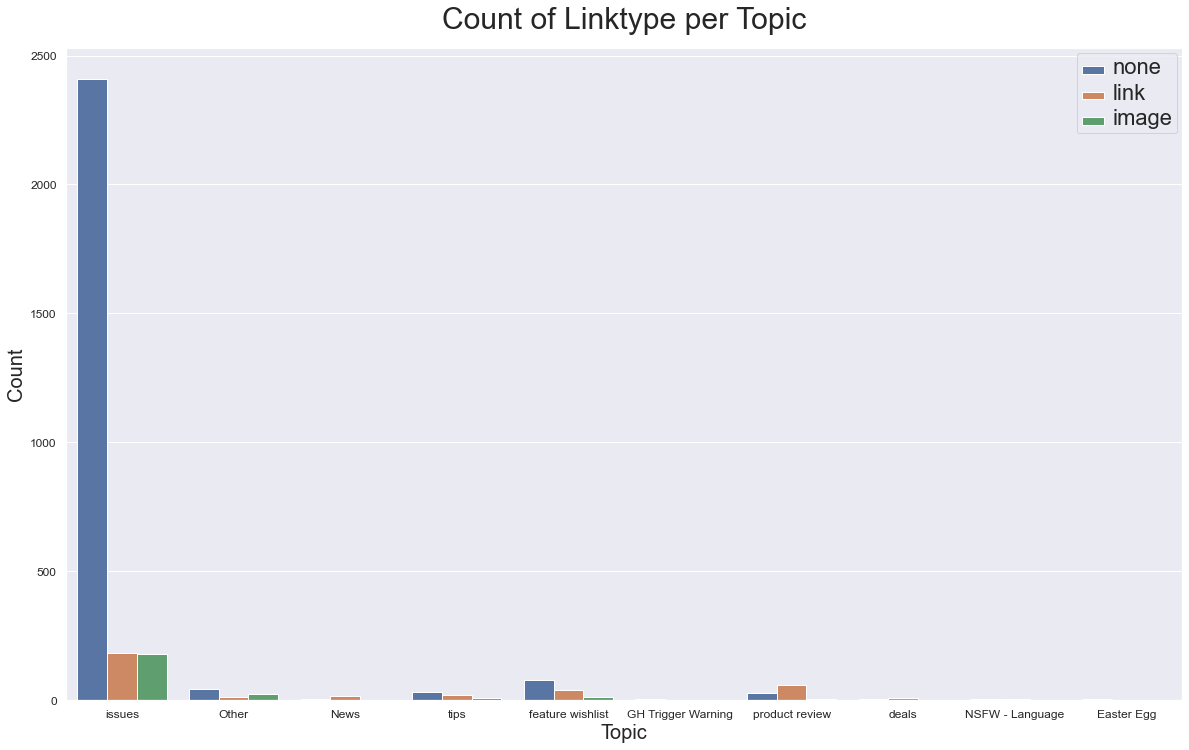

In [34]:
plt.figure(figsize=(20,12))
bar = sns.countplot(data=subreddit_data, hue='linktype',x='topic')
bar.set_title("Count of Linktype per Topic",fontsize=30,y=1.02)
bar.set_xlabel("Topic",fontsize=20)
bar.set_ylabel("Count",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='upper right')
plt.setp(bar.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(bar.get_legend().get_title(), fontsize='22')
plt.savefig(r'../images/count-of-linktype-per-topic.png');

Against my own assumptions, I had though that images would fair the highest under issues thinking that many authors would share pictures regarding where their issues lie for easier troubleshooting. Images and link are the highest compared to other topics, however compared to not having any types of links in their post, the bar chart above shows that majority of post are only text.

## Find distribution of word counts

I would like to find the distribution of words for post in the respective reddits

In [35]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit_              5733 non-null   object
 1   author_                 5733 non-null   object
 2   full_link               5733 non-null   object
 3   num_comments            5733 non-null   int64 
 4   url_overridden_by_dest  985 non-null    object
 5   selftext_               5733 non-null   object
 6   title_                  5733 non-null   object
 7   topic                   3197 non-null   object
 8   url_in_text             219 non-null    object
 9   has_url                 1198 non-null   object
 10  linktype                5733 non-null   object
dtypes: int64(1), object(10)
memory usage: 492.8+ KB


In [36]:
#create new column called 'word_count'

subreddit_data['word_count'] = None

#use for loop to iterate through all df
for row in range(0,len(subreddit_data)):
    """intead of using .split() method which
    separates by only white space, using the re.sub 
    method will also replace punctuation"""
    num_words = len(re.sub('[^\w\s]','',subreddit_data.iat[row,5]).split())
    subreddit_data.iat[row,11] = num_words

subreddit_data['word_count'] = pd.to_numeric(subreddit_data['word_count'])

In [37]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit_              5733 non-null   object
 1   author_                 5733 non-null   object
 2   full_link               5733 non-null   object
 3   num_comments            5733 non-null   int64 
 4   url_overridden_by_dest  985 non-null    object
 5   selftext_               5733 non-null   object
 6   title_                  5733 non-null   object
 7   topic                   3197 non-null   object
 8   url_in_text             219 non-null    object
 9   has_url                 1198 non-null   object
 10  linktype                5733 non-null   object
 11  word_count              5733 non-null   int64 
dtypes: int64(2), object(10)
memory usage: 537.6+ KB


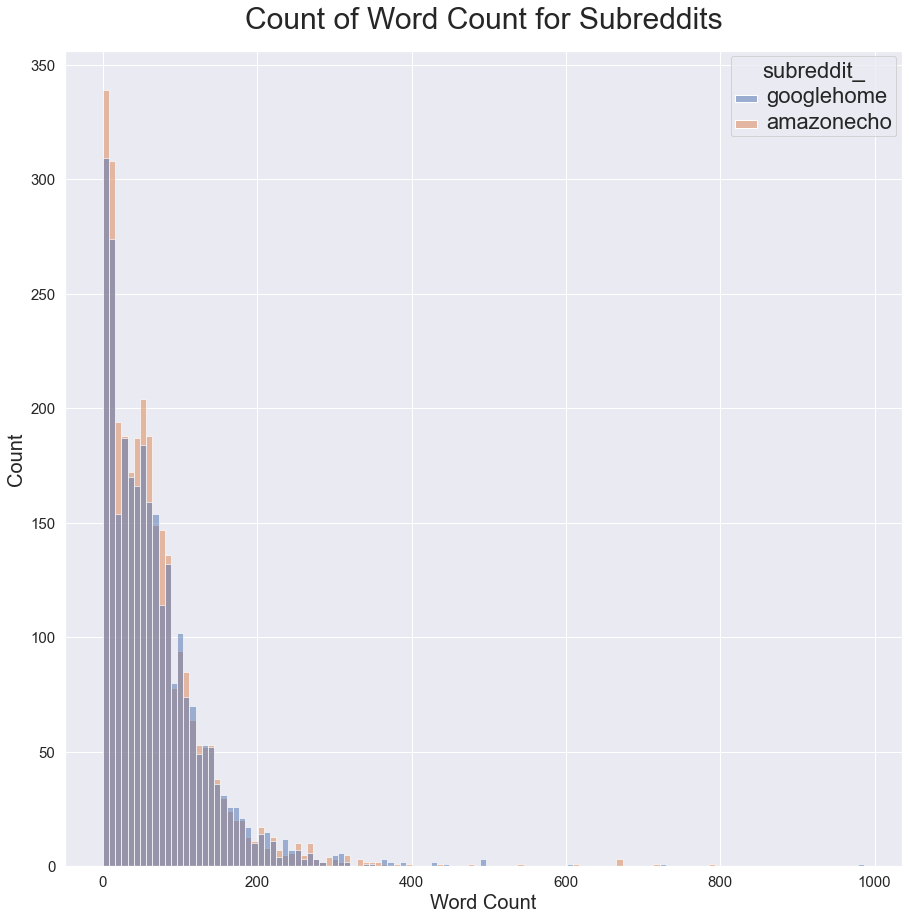

In [38]:
#plot distribution of word count per subreddit
sns.set(style="darkgrid")
plt.figure(figsize = (15,15))

hist = sns.histplot(data = subreddit_data, x = 'word_count', hue = 'subreddit_')

hist.set_title("Count of Word Count for Subreddits",fontsize=30,y=1.02)
hist.set_xlabel("Word Count",fontsize=20)
hist.set_ylabel("Count",fontsize=20)
hist.tick_params(axis='both', which='major', labelsize=15)
plt.setp(hist.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(hist.get_legend().get_title(), fontsize='22');

<b>observation</b>: 
 The distribution of the word count for the respective subreddits have the same distribution. Although Google Home Subreddit have more words in certain bins. 

After 400 words there are some outliers. It would be interesting to explore these posts to understand the reason for the lengthy post. 

### further investigation of highest word counts in respective subreddits

In [39]:
#show link of Google Home subreddit with highest word count

print(f"Link of Google Home subreddit with highest word count: {subreddit_data[subreddit_data.subreddit_=='googlehome'].sort_values(by=['word_count'],ascending=False).iloc[0,2]}")

Link of Google Home subreddit with highest word count: https://www.reddit.com/r/googlehome/comments/lj77ss/2nd_gen_nest_minis_others_that_frequently/


From the above link, this Google home post with the highest word count had shared their chat with a Google customer support staff. Where they had connective issues with the product and was not satisfied with the staff's service.

In [40]:
#show link of Amazon Echo subreddit with highest word count

print(f"Link of Amazon Echo subreddit with highest word count: {subreddit_data[subreddit_data.subreddit_=='amazonecho'].sort_values(by=['word_count'],ascending=False).iloc[0,2]}")

Link of Amazon Echo subreddit with highest word count: https://www.reddit.com/r/amazonecho/comments/ktxcx4/some_questions_from_a_newb_about_setting_up/


From the above link, the author of this Amazon Echo post is describing several issues with the product however is contextualizing them in great detail.

From the above observations, it would be interesting to see if there is a correlation between sentiment and number of words. THe assumption is that people tend to write more when they are expressing fustration. A sentiment analyzer would therefore be need to measure the post's sentiment.

In [41]:
#Find Average words per post per Subreddit

#total words of all Google Home posts
total_ggl_wrds = subreddit_data[subreddit_data.subreddit_=='googlehome']['word_count'].sum()

#total Google Home posts
no_ggl_posts = len(subreddit_data[subreddit_data.subreddit_=='googlehome'])

#total words of all Amazon Echo posts
total_amz_wrds = subreddit_data[subreddit_data.subreddit_=='amazonecho']['word_count'].sum()

#total Amazon Echo posts
no_amz_posts = len(subreddit_data[subreddit_data.subreddit_=='amazonecho'])

print(f'Words per Google Home post: {round(total_ggl_wrds/no_ggl_posts)}')
print(f'Words per Amazon Echo post: {round(total_amz_wrds/no_amz_posts)}')

Words per Google Home post: 69
Words per Amazon Echo post: 67


<b>Summary Statistic<b/>:

    
|             	| No. of Posts 	| No.of post w/ image 	| No. of Post w/ link 	| Customer Support Mentioned 	| Words per Post 	|
|-------------	|--------------	|---------------------	|---------------------	|----------------------------	|----------------	|
| Google Home 	| 2968         	| 258                 	| 394                 	| 31                         	| 69             	|
| Amazon Echo 	| 2767         	| 165                 	| 381                 	| 17                         	| 67             	|

## Find most frequently used words and bigrams

In [42]:
#set X_ggl as clean text of Google Home post
X_ggl = subreddit_data[subreddit_data.subreddit_ == 'googlehome']['selftext_']

#set X_amz as clean text of Amazon post
X_amz = subreddit_data[subreddit_data.subreddit_ == 'amazonecho']['selftext_']

In [43]:
# Instantiate the transformer.
cvec = CountVectorizer(stop_words='english')

#put converted data into respective dataframe
ggl_cv_df = pd.DataFrame(cvec.fit_transform(X_ggl).todense(), 
                          columns=cvec.get_feature_names())

amz_cv_df = pd.DataFrame(cvec.fit_transform(X_amz).todense(), 
                          columns=cvec.get_feature_names())

In [44]:
print(f'Google Home CountVectorizer df shape: {ggl_cv_df.shape}')
print(f'Amazon Echo CountVectorizer df shape: {amz_cv_df.shape}')

Google Home CountVectorizer df shape: (2765, 8165)
Amazon Echo CountVectorizer df shape: (2968, 8068)


In [45]:
ggl_cv_df.sum().sort_values(ascending=False).head(20)


google     3276
home       2172
nest        952
just        936
app         824
like        721
set         703
play        687
music       629
mini        614
ve          590
turn        563
phone       555
tv          543
hub         526
device      508
speaker     500
time        499
devices     499
lights      498
dtype: int64

In [46]:
amz_cv_df.sum().sort_values(ascending=False).head(20)

echo       2639
alexa      2037
amazon     1125
just        970
music       857
play        794
app         788
dot         753
like        699
ve          668
set         604
device      560
devices     551
use         523
turn        517
way         513
want        508
know        461
room        447
does        435
dtype: int64

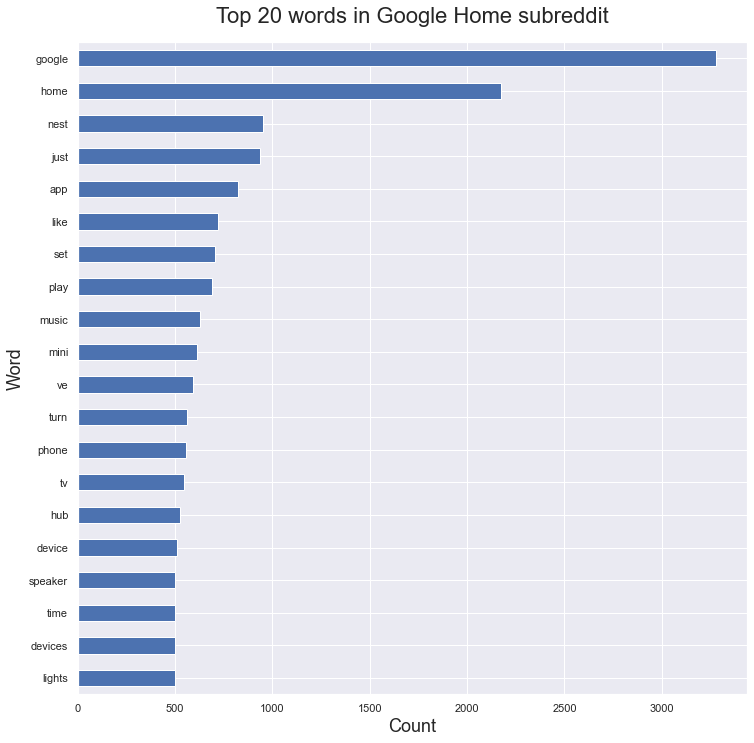

In [47]:
# plot Google Home top occuring words
sns.set(style="darkgrid")
ggl_cv_df.sum().sort_values(ascending=False).head(20)[::-1].plot(kind='barh',figsize=(12, 12), rot=0)
plt.title("Top 20 words in Google Home subreddit", y=1.02, fontsize = 22)
plt.xlabel("Count",fontsize=18)
plt.ylabel("Word",fontsize=18);

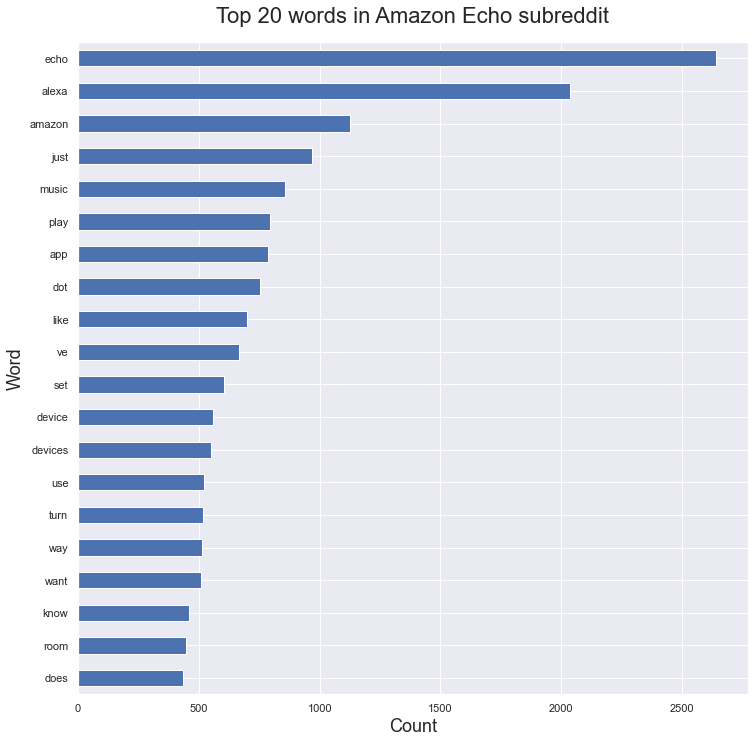

In [48]:
# plot top Amazon Echo occuring words
sns.set(style="darkgrid")
amz_cv_df.sum().sort_values(ascending=False).head(20)[::-1].plot(kind='barh',figsize=(12, 12), rot=0)
plt.title("Top 20 words in Amazon Echo subreddit", y=1.02, fontsize = 22)
plt.xlabel("Count",fontsize=18)
plt.ylabel("Word",fontsize=18);

In [49]:
#make common words respective subreddits into list

ggl_common_words = ggl_cv_df.sum().sort_values(ascending=False).head(20).index.to_list()

amz_common_words = amz_cv_df.sum().sort_values(ascending=False).head(20).index.to_list()

In [50]:
#make list of common words
mutual_common_words = list(set(amz_common_words).intersection(ggl_common_words))

print (f'List of common words in both subreddits: {mutual_common_words}')

List of common words in both subreddits: ['set', 'play', 'like', 'just', 'app', 'devices', 'music', 've', 'device', 'turn']


In [51]:
unique_ggl_words = [x for x in ggl_common_words if x not in amz_common_words]

print (f'List of top unique common words in Google Home subreddits: {unique_ggl_words}')

List of top unique common words in Google Home subreddits: ['google', 'home', 'nest', 'mini', 'phone', 'tv', 'hub', 'speaker', 'time', 'lights']


In [52]:
unique_amz_words = [x for x in amz_common_words if x not in ggl_common_words]

print (f'List of top unique common words in Amazon Echo subreddits: {unique_amz_words}')

List of top unique common words in Amazon Echo subreddits: ['echo', 'alexa', 'amazon', 'dot', 'use', 'way', 'want', 'know', 'room', 'does']


<b>Observation</b>: There are common words from both subreddits, such as 'app', 'device','music','devices' and 'music' which indicates possibly describing issues in these areas of the products. Perhaps the respective apps can abe buggy and playing music is where the products have connectivity problems.

As for unique words, obvious ones are the brand name such as 'Google' and 'Amazon' which is not very useful information. However in unique words in Google Home subreddit, 'mini' which is a new google product is present similar to 'dot' in the Amazon Echo subreddit. 

In Google Echo subreddit, words such as 'tv','phone','speaker' and 'lights' are present and not in the Amazon Echo subreddit. A supposition could be that owners of Google Home seem to have more specific issues as they do not turn up in the Amazon Echo unique word. 

Moving forward count of bigrams are to be explored.

In [53]:
# Instantiate the transformer for bigram.
cvec = CountVectorizer(stop_words='english',ngram_range=(2,2))

#put converted data into respective dataframe
ggl_cv_df = pd.DataFrame(cvec.fit_transform(X_ggl).todense(), 
                          columns=cvec.get_feature_names())

amz_cv_df = pd.DataFrame(cvec.fit_transform(X_amz).todense(), 
                          columns=cvec.get_feature_names())

In [54]:
print(f'Google Home CountVectorizer(bigram) df shape: {ggl_cv_df.shape}')
print(f'Amazon Echo CountVectorizer(bigram) df shape: {amz_cv_df.shape}')

Google Home CountVectorizer(bigram) df shape: (2765, 58940)
Amazon Echo CountVectorizer(bigram) df shape: (2968, 60194)


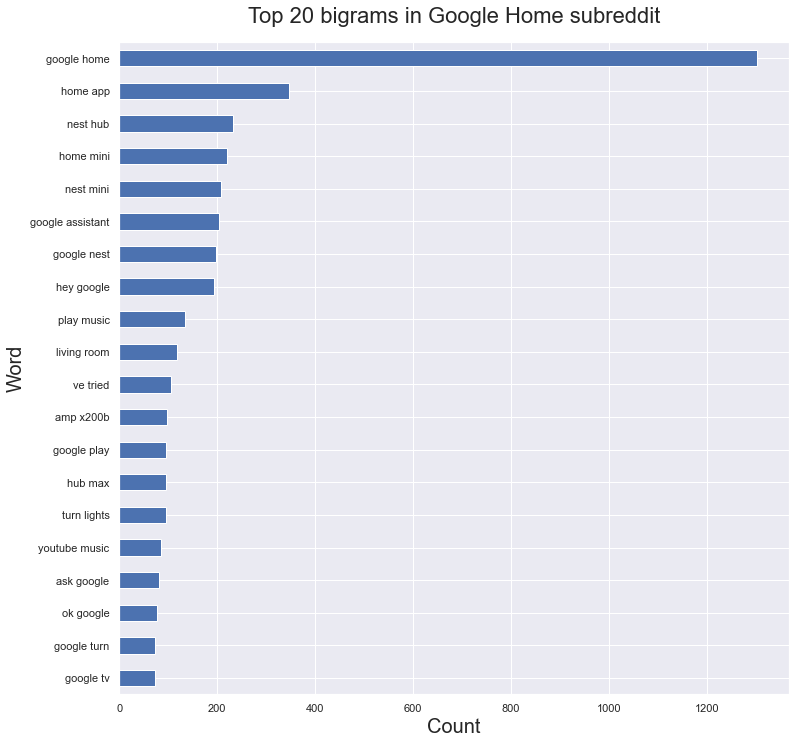

In [55]:
# plot Google Home top occuring bigrams
sns.set(style="darkgrid")
ggl_cv_df.sum().sort_values(ascending=False).head(20)[::-1].plot(kind='barh',figsize=(12, 12), rot=0)
plt.title("Top 20 bigrams in Google Home subreddit", y=1.02, fontsize = 22)
plt.xlabel("Count",fontsize=20)
plt.ylabel("Word",fontsize=20)
plt.savefig(r'../images/top-20-bigrams-google.png');

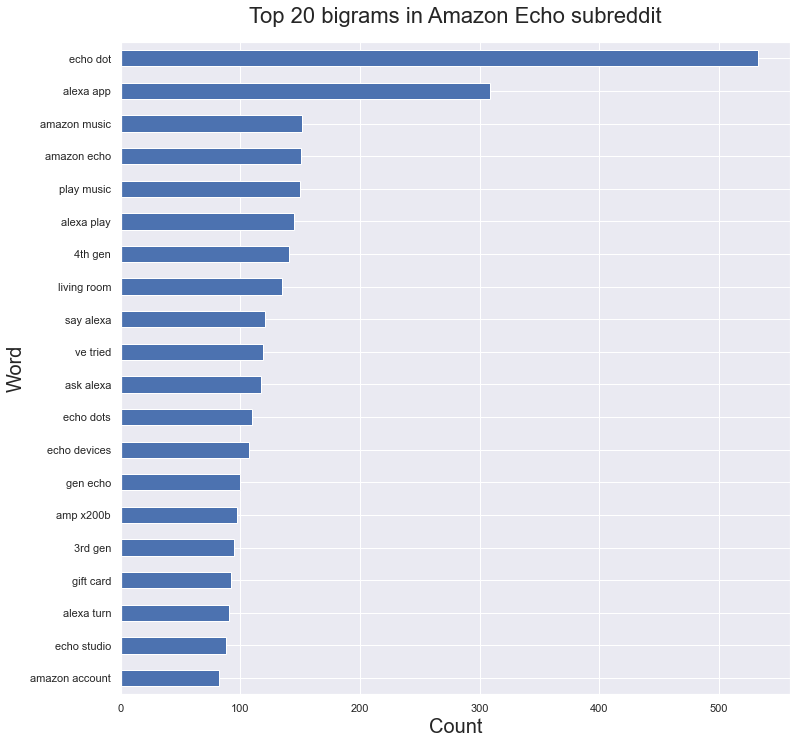

In [56]:
# plot top Amazon Echo occuring bigrams
sns.set(style="darkgrid")
amz_cv_df.sum().sort_values(ascending=False).head(20)[::-1].plot(kind='barh',figsize=(12, 12), rot=0)
plt.title("Top 20 bigrams in Amazon Echo subreddit", y=1.02, fontsize = 22)
plt.xlabel("Count",fontsize=20)
plt.ylabel("Word",fontsize=20)
plt.savefig(r'../images/top-20-bigrams-amazon.png');

<b>Observation</b>: From the above bar graphs of the respective subreddit top 20 bigrams, it has perhaps uncovered customer pain points more clearly. 

For both subreddits, 'home app' and 'alexa app' appear, suggesting that most of the issues are software related. Additionally, bigrams such as 'hey google' and 'alexa play' shows issues with voice prompts as well as 'youtube music' and 'play music' shows issues with playing music. 

'Living room' also appears in both subreddits, suggesting that this is a common area for the placement of these products.

Furthermore in both subreddits, the mention of newer and older models are in the top 20, as well as other products that pairs with them. For example 'home mini' is the newer models for Google Home. And 'echo dot','4th gen','3rd gen' for Amazon Echo are both older and new models. 'Google Nest' and 'Nest Mini' are additional device to pair with the Google home. 

### Create new dfs without keywords

In [57]:
additional_words = ['google','amazon','mini','dot','hub','max','echo','alexa','assistant','nest','amp','x200b']

stop_words = set(text.ENGLISH_STOP_WORDS.union(additional_words))

# Instantiate the transformer for bigram with no key words(nkw)
cvec_nkw = CountVectorizer(stop_words=stop_words,ngram_range=(2,2))

#put converted data into respective dataframe
ggl_cv_nkw_df = pd.DataFrame(cvec_nkw.fit_transform(X_ggl).todense(), 
                          columns=cvec_nkw.get_feature_names())

amz_cv_nkw_df = pd.DataFrame(cvec_nkw.fit_transform(X_amz).todense(), 
                          columns=cvec_nkw.get_feature_names())

In [58]:
print(f'Google Home CountVectorizer(bigram) w/o keywords df shape: {ggl_cv_nkw_df.shape}')
print(f'Amazon Echo CountVectorizer(bigram) w/o keywords df shape: {amz_cv_nkw_df.shape}')

Google Home CountVectorizer(bigram) w/o keywords df shape: (2765, 57765)
Amazon Echo CountVectorizer(bigram) w/o keywords df shape: (2968, 59055)


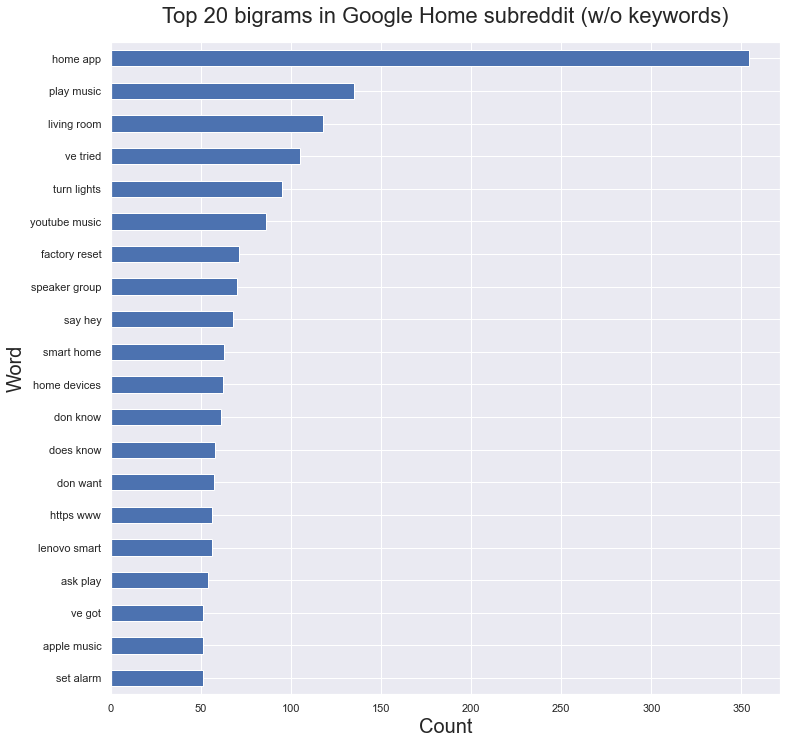

In [59]:
# plot Google Home top occuring bigrams w/o keywords
sns.set(style="darkgrid")
ggl_cv_nkw_df.sum().sort_values(ascending=False).head(20)[::-1].plot(kind='barh',figsize=(12, 12), rot=0)
plt.title("Top 20 bigrams in Google Home subreddit (w/o keywords)", y=1.02, fontsize = 22)
plt.xlabel("Count",fontsize=20)
plt.ylabel("Word",fontsize=20);

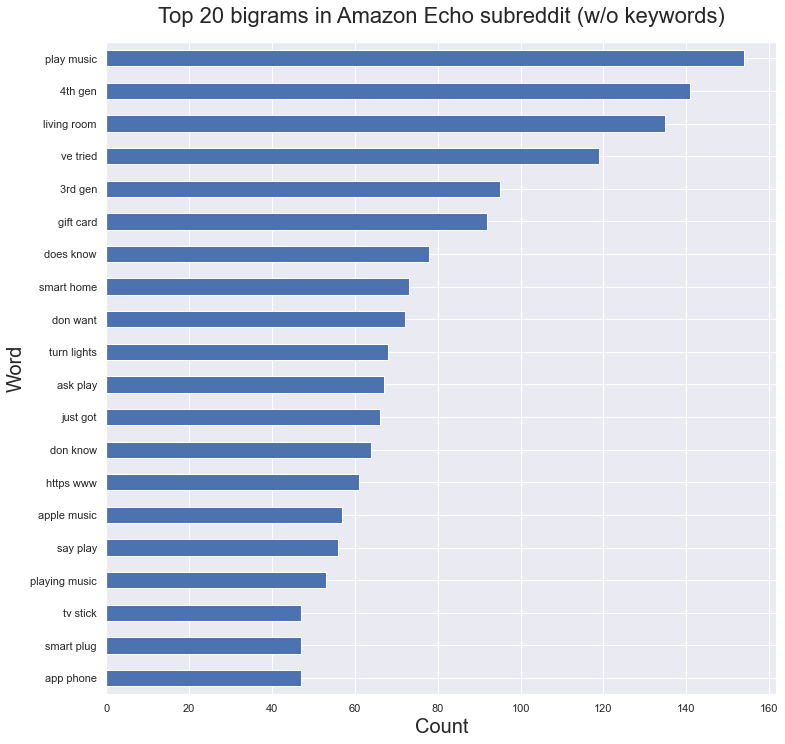

In [60]:
# plot top Amazon Echo occuring bigrams
sns.set(style="darkgrid")
amz_cv_nkw_df.sum().sort_values(ascending=False).head(20)[::-1].plot(kind='barh',figsize=(12, 12), rot=0)
plt.title("Top 20 bigrams in Amazon Echo subreddit (w/o keywords)", y=1.02, fontsize = 22)
plt.xlabel("Count",fontsize=20)
plt.ylabel("Word",fontsize=20);

After removing the key words, we did not find any particularly new or exciting insights. However with regards to Google Home subreddits, perhaps a new insight would be the mention of lenovo smart and apple music. My assumption is the synchronization between the Google Home and these specific device and software has issues. 

## Sentiment Analysis with Vader lexicon

Conducting a sentiment would be useful to quantify the average sentiment of posts per subreddits, correlations between other features would also be interesting to see.

In [61]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit_              5733 non-null   object
 1   author_                 5733 non-null   object
 2   full_link               5733 non-null   object
 3   num_comments            5733 non-null   int64 
 4   url_overridden_by_dest  985 non-null    object
 5   selftext_               5733 non-null   object
 6   title_                  5733 non-null   object
 7   topic                   3197 non-null   object
 8   url_in_text             219 non-null    object
 9   has_url                 1198 non-null   object
 10  linktype                5733 non-null   object
 11  word_count              5733 non-null   int64 
dtypes: int64(2), object(10)
memory usage: 537.6+ KB


In [62]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()

In [63]:
#create new column sentiment_score

subreddit_data['sentiment_score'] = None

for row in range(0,len(subreddit_data)):
    sentscore = sent.polarity_scores(subreddit_data.iat[row,5])['compound']
    subreddit_data.iat[row,12] = sentscore

In [64]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit_              5733 non-null   object
 1   author_                 5733 non-null   object
 2   full_link               5733 non-null   object
 3   num_comments            5733 non-null   int64 
 4   url_overridden_by_dest  985 non-null    object
 5   selftext_               5733 non-null   object
 6   title_                  5733 non-null   object
 7   topic                   3197 non-null   object
 8   url_in_text             219 non-null    object
 9   has_url                 1198 non-null   object
 10  linktype                5733 non-null   object
 11  word_count              5733 non-null   int64 
 12  sentiment_score         5733 non-null   object
dtypes: int64(2), object(11)
memory usage: 582.4+ KB


In [65]:
subreddit_data['sentiment_score'] = pd.to_numeric(subreddit_data['sentiment_score'])

In [66]:
subreddit_data[subreddit_data.subreddit_ == 'googlehome']['sentiment_score'].describe()

count    2765.000000
mean        0.251506
std         0.504512
min        -0.985400
25%         0.000000
50%         0.312900
75%         0.700300
max         0.997700
Name: sentiment_score, dtype: float64

In [67]:
subreddit_data[subreddit_data.subreddit_ == 'amazonecho']['sentiment_score'].describe()

count    2968.000000
mean        0.273620
std         0.509966
min        -0.981100
25%         0.000000
50%         0.340000
75%         0.728800
max         0.997200
Name: sentiment_score, dtype: float64

From the above, we can see that Amazon Echo posts, marginally beats Google Home post in terms of sentiment score in all areas.

<b>Summary Statistic<b/>:

|             	| No. of Posts 	| No.of post w/ image 	| No. of Post w/ link 	| Customer Support Mentioned 	| Words per Post 	| Average Sentiment 	|
|-------------	|--------------	|---------------------	|---------------------	|----------------------------	|----------------	|-------------------	|
| Google Home 	| 2968         	| 258                 	| 394                 	| 31                         	| 69             	| 0.252             	|
| Amazon Echo 	| 2767         	| 165                 	| 381                 	| 17                         	| 67             	| 0.274             	|

## Finding Correlation Between Features

In [68]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subreddit_              5733 non-null   object 
 1   author_                 5733 non-null   object 
 2   full_link               5733 non-null   object 
 3   num_comments            5733 non-null   int64  
 4   url_overridden_by_dest  985 non-null    object 
 5   selftext_               5733 non-null   object 
 6   title_                  5733 non-null   object 
 7   topic                   3197 non-null   object 
 8   url_in_text             219 non-null    object 
 9   has_url                 1198 non-null   object 
 10  linktype                5733 non-null   object 
 11  word_count              5733 non-null   int64  
 12  sentiment_score         5733 non-null   float64
dtypes: float64(1), int64(2), object(10)
memory usage: 582.4+ KB


Features to assess correlation:<br>
    - linktype (to dummify)<br>
    - word_count<br>
    - sentiment_score<br>
    - num_comments<br>

In [69]:
#dummify linktype
linktype_dummy = pd.get_dummies(data = subreddit_data.linktype)

In [70]:
#cocat other features with dummified linktype

corr_df = pd.concat([subreddit_data[['word_count','sentiment_score','num_comments']],linktype_dummy],axis=1)

In [71]:
#check new df
corr_df.head()

,word_count,sentiment_score,num_comments,image,link,none
0,169,0.8253,0,0,0,1
1,71,0.7717,0,0,0,1
2,53,0.1027,0,0,1,0
3,7,-0.4019,2,0,0,1
4,53,-0.2382,0,0,0,1


In [72]:
#show correlation table
corr_df.corr()

,word_count,sentiment_score,num_comments,image,link,none
word_count,1.000000,0.161658,0.032622,-0.169921,-0.222316,0.296237
sentiment_score,0.161658,1.000000,-0.036984,-0.085267,-0.031119,0.081041
num_comments,0.032622,-0.036984,1.000000,0.135934,-0.017115,-0.073113
image,-0.169921,-0.085267,0.135934,1.000000,-0.111648,-0.549841
link,-0.222316,-0.031119,-0.017115,-0.111648,1.000000,-0.768659
none,0.296237,0.081041,-0.073113,-0.549841,-0.768659,1.000000


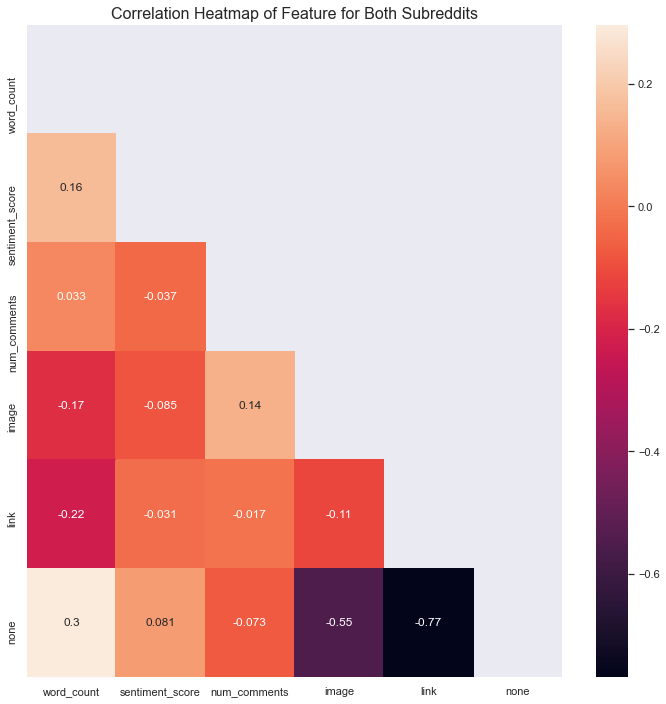

In [73]:
#plot correlation heatmap

plt.figure(figsize=(12,12))
plt.title('Correlation Heatmap of Feature for Both Subreddits',fontsize =16)

sns.heatmap(data=corr_df.corr(),annot=True,mask=np.triu(corr_df.corr()))
plt.savefig(r'../images/corr-heatmap.png');

<b>Observations:</b><br>
    - Most features have weak correlation relationships with each other, making them independent features.<br> 
    - Num_comments has a positive relationship to image. Suggesting that people tend to engage more with post that includes pictures.<br>
    - sentiment_score also have a negative relationship to image. This is likely due to authors posting issues with their product acompanied by an image.<br>
    - Against my own intuition, sentiment_score has a postive relationship with number of words, I had expected a negative relationship as people tend to write lengthier posts when they are upset. Although this postivie relationship is still rather weak.<br>

<b>Summary Statistic:</b><br>

|             	| No. of Posts 	| No.of post w/ image 	| No. of Post w/ link 	| Customer Support Mentioned 	| Words per Post 	| Average Sentiment 	|
|-------------	|--------------	|---------------------	|---------------------	|----------------------------	|----------------	|-------------------	|
| Google Home 	| 2968         	| 258                 	| 394                 	| 31                         	| 69             	| 0.252             	|
| Amazon Echo 	| 2767         	| 165                 	| 381                 	| 17                         	| 67             	| 0.274             	|

## Conclusion

<b>Questions answered:</b>
    
<b>What are people on subreddits generally discussing about?</b>

From our topic type bar graph, majority of topic discussion is regarding trouble shooting problems they are facing with the product. Additionally from our top 20 bigram bar graph, we see that the Google Home Mini is often mentioned. Suggesting that people are comparing their Google Home to the Home Mini, most likely weighing the pros and cons between them. This also applies to Amazon Echo and the Echo Dot. 

<b>Do people find the respective customer support site helpful?</b>

When searching for key words such as 'Google Support' and 'support.google.com' only 31 times out of 2968 posts, approximately 1%, compared to Amazon of 0.6%. This may show that owners of the Google Home either have tried Google's customer support and do not find it useful to suggest it as a solution to other owners. An alternative inference is authors that have mentioned customer support are lamenting their experience. 

<b> How does Google Home match up to Amazon Echo? Are customer pain points identified?</b>

From the sentiment analysis, on average Amazon echo has a higher compound score, although marginal. 

- Software issues, related to playing music mostly such as apple and youtube music based on the most common words.
- Also pairing with the lenovo smart clock as the bigram seem to appear frequently.
- Voice command prompts seem to be mentioend a lot as well this evident in both subreddit which suggest it is a common issue amongst the products. 

<b>What can be reccomended to further improve the product and customer service around it?</b>

Learn from these posts to improve Google Support site. Although it may not directly relate to increase in revenue, instead of having to resort to looking for solutions on a subreddit where you may not always have your issue addressed. Highly dependent if people reply to you post. 
    

## Exporting data for modelling

Before exporting the data we would want to make some feature engineering to fully prepare our data. 

In [74]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subreddit_              5733 non-null   object 
 1   author_                 5733 non-null   object 
 2   full_link               5733 non-null   object 
 3   num_comments            5733 non-null   int64  
 4   url_overridden_by_dest  985 non-null    object 
 5   selftext_               5733 non-null   object 
 6   title_                  5733 non-null   object 
 7   topic                   3197 non-null   object 
 8   url_in_text             219 non-null    object 
 9   has_url                 1198 non-null   object 
 10  linktype                5733 non-null   object 
 11  word_count              5733 non-null   int64  
 12  sentiment_score         5733 non-null   float64
dtypes: float64(1), int64(2), object(10)
memory usage: 582.4+ KB


Moving forward, the features that would be used in our modelling are sentiment_score, word_count, linktype, selftext_, num_comments, subreddit_.

In [75]:
modelling_data = subreddit_data[['sentiment_score', 'word_count', 'linktype', 'selftext_', 'num_comments', 'subreddit_']]

In [76]:
modelling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_score  5733 non-null   float64
 1   word_count       5733 non-null   int64  
 2   linktype         5733 non-null   object 
 3   selftext_        5733 non-null   object 
 4   num_comments     5733 non-null   int64  
 5   subreddit_       5733 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 268.9+ KB


In [77]:
#export dataset as modelling data

modelling_data.to_csv(r'../datasets/modelling_data.csv',index=False)